In [1]:
%matplotlib inline
import matplotlib_inline
import warnings

# matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')
warnings.filterwarnings('ignore')

import csv
import numpy as np
import scipy as sp
from CoolProp import CoolProp as cpr
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import interp1d, interp2d
from scipy.special import *

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ["Computer Modern Roman"]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.markersize'] = 5

# Simulación directa - DNS

In [2]:
dt = 2.5e-3
dx = 1e-2

t0 = 0
tf = 300
xf = 1

t = np.arange(t0, tf + dt, dt)
x = np.arange(0, xf + dx, dx)

Nx = len(x) - 1
Nt = len(t) - 1

In [3]:
CFL = dt/dx
print('CFL = ', CFL)

CFL =  0.25


In [4]:
# Initialization
Tf = np.zeros((Nx+1, Nt+1))
Ts = np.zeros((Nx+1, Nt+1))

Tin = 0

# BCs
Tf[0,:] = Tin

# ICs
Tf[:,0] = 0
Ts[:,0] = 0

In [5]:
'''Xi =  0.0013
kappa =  235.0374
R/L =  2.0
Rep =  13723.4655
Re =  3659590.8011
Lambda =  [36.4074 28.3169 22.5379 18.2037 12.1358]
Lambdas =  [0.0154 0.0154 0.0154 0.0154 0.0154]
beta =  0.0064
betas =  1.5
eps =  [0.25 0.3  0.35 0.4  0.5 ]
gamma =  [0.0004 0.0005 0.0007 0.0008 0.0013]'''

xi = 0.0013
kappa = 235.0374
eps = 0.5

Lambda = 100
Lambdas = Lambda*xi*eps/(1-eps)
beta =  0.1
betas = kappa*beta

# gamma =  (1 - eps)*Lambdas/Lambda
gamma = Lambdas/Lambda

print('Lambda = ', np.round(Lambda, 4))
print('Lambdas = ', np.round(Lambdas, 4))
print('beta = ', np.round(beta, 4))
print('betas = ', np.round(betas, 4))
print('gamma = ', np.round(gamma, 4))

Lambda =  100
Lambdas =  0.13
beta =  0.1
betas =  23.5037
gamma =  0.0013


In [6]:
# Matrix terms
p = dt/dx

q = beta*dt/(dx**2)
qs = betas*dt/(dx**2)

r = Lambda*dt
rs = Lambdas*dt

In [7]:
# Explicit form of heat transfer term
diagonals = [np.ones(Nx)*(1 + 2*q + r + p), np.ones(Nx)*(-q), np.ones(Nx)*(-p-q)]

offsets = [0, 1, -1]
A = sp.sparse.diags(diagonals, offsets).toarray()
A[-1,-2] = -2*q - p
A[-1,-1] = 1 + 2*q + r + p + 2*q/p

A = sp.sparse.csr_matrix(A)

In [8]:
# Explicit form of heat transfer term
diagonals = [np.ones(Nx + 1)*(1 + 2*qs + rs), np.ones(Nx + 1)*(-qs), np.ones(Nx + 1)*(-qs)]

offsets = [0, 1, -1]
As = sp.sparse.diags(diagonals, offsets).toarray()
As[-1,-2] = -2*qs
As[0,1] = -2*qs

As = sp.sparse.csr_matrix(As)

In [9]:
bc0 = np.zeros(Nx)
bc1 = np.zeros(Nx)

bc0[0] = Tin
bc1[-1] = 1

In [10]:
AA = sp.sparse.block_diag((sp.sparse.linalg.inv(A), sp.sparse.linalg.inv(As)))

Heat source

In [11]:
Delta = 0.5
x0 = 0.8
delta = 0.005

# Q = (np.tanh(t/Delta)*np.exp(-(1/delta)*(x[:,np.newaxis] - x0)**2)/np.sqrt(np.pi*delta) +
#     np.tanh(t/Delta)*np.exp(-(1/delta)*(x[:,np.newaxis] - 0.5)**2)/np.sqrt(np.pi*delta) +
#     np.tanh(t/Delta)*np.exp(-(1/delta)*(x[:,np.newaxis] - 0.2)**2)/np.sqrt(np.pi*delta))/3

Q = np.tanh(t/Delta)*np.exp(-(1/delta)*(x[:,np.newaxis] - x0)**2)/np.sqrt(np.pi*delta)

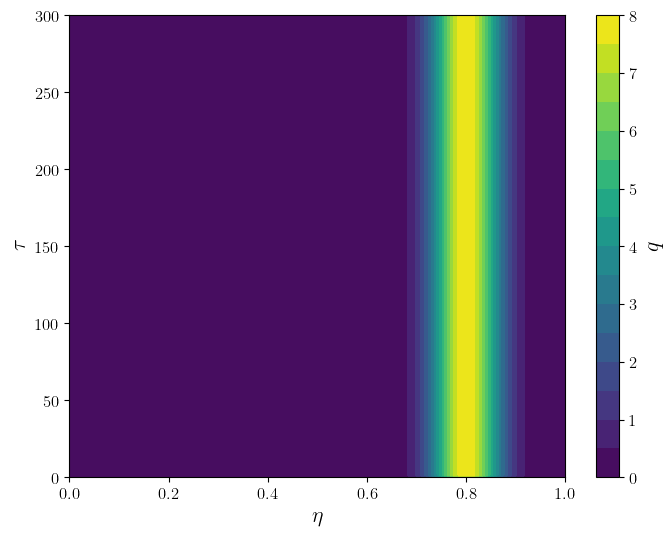

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

cs1 = plt.contourf(x, t, Q.T, 16, rasterized=True)
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$q$', fontsize=16)
ax.set_xlabel(r'$\eta$', fontsize=16)
ax.set_ylabel(r'$\tau$', fontsize=16)

fig.savefig('./figs/q_vs_tau_vs_eta' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')

plt.show()

Numerical solution

In [13]:
for i in range(1,Nt+1):
    
    bc1[-1] = 2*q/p*Tf[-1,i-1]
#     TT = np.concatenate([Tf[1:Nx+1,i-1] + (q + p)*bc0 + r*Ts[1:,i-1] + bc1 + eps*dt*Q[1:,i-1],
#                          Ts[:,i-1] + rs*Tf[:Nx+1,i-1] + dt*gamma*Q[:,i-1]])

    TT = np.concatenate([Tf[1:Nx+1,i-1] + (q + p)*bc0 + r*Ts[1:,i-1] + bc1,
                         Ts[:,i-1] + rs*Tf[:Nx+1,i-1] + dt*gamma*Q[:,i-1]])  
    
    sol = AA.dot(TT)
    
    Tf[1:Nx+1,i] = sol[:Nx]
    Ts[:,i] = sol[Nx:]
    

In [14]:
thetaf = Tf
thetas = Ts

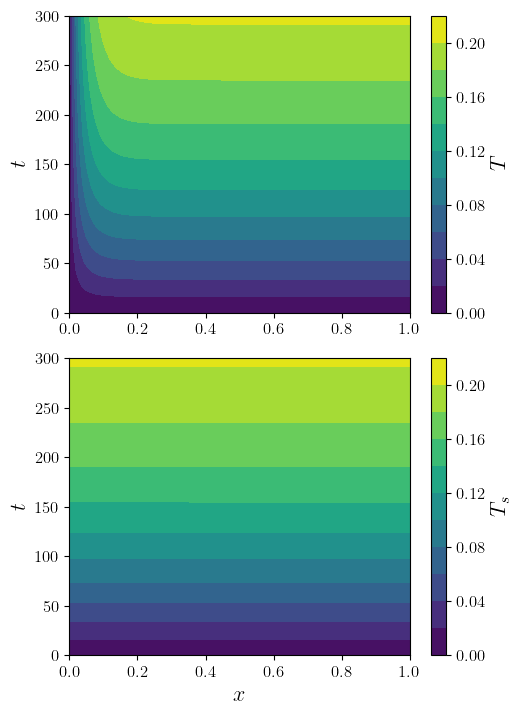

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,7), sharex='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(x, t, thetaf.T, 12, rasterized=True)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax1.set_ylabel(r'$t$', fontsize=16)
# ax1.plot(x, x,'r--', label=r'$x = t$')

cs2 = ax2.contourf(x, t, thetas.T, 12, rasterized=True)
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$', fontsize=16)
ax2.set_xlabel(r'$x$', fontsize=16)
ax2.set_ylabel(r'$t$', fontsize=16)
# ax2.plot(x, x,'r--')
ax2.set_xlim([0, 1])

fig.savefig('./figs/DNS_T_vs_x_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

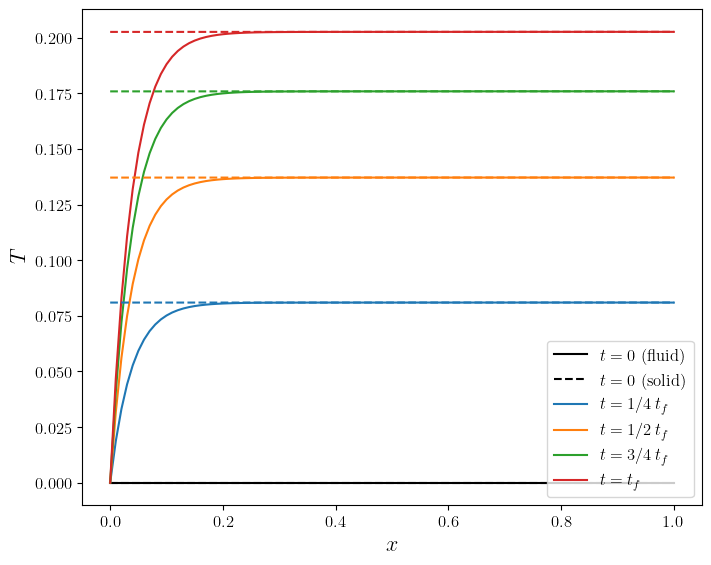

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

plt.plot(x, thetaf[:,0], 'k', x, thetas[:,0], 'k--',
         x, thetaf[:,int(1/4*len(t))], 
         x, thetaf[:,int(2/4*len(t))],
         x, thetaf[:,int(3/4*len(t))],
         x, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(x, thetas[:,int(1/4*len(t))], '--', 
         x, thetas[:,int(2/4*len(t))], '--',
         x, thetas[:,int(3/4*len(t))], '--',
         x, thetas[:,-1], '--')

plt.legend([r'$t = 0$ (fluid)', r'$t = 0$ (solid)', r'$t = 1/4 \,t_f$',
            r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'])

ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
# ax.set_ylim([-1,0])

fig.savefig('./figs/DNS_Tf_Ts_vs_x_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

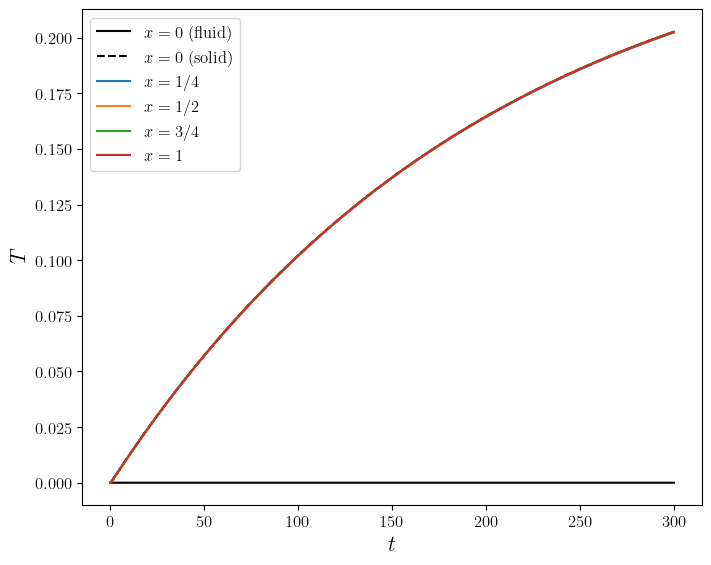

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(t, thetaf[0,:], 'k-', t, thetas[0,:], 'k--',
         t, thetaf[int(1*len(x)/4),:],
         t, thetaf[int(2*len(x)/4),:], 
         t, thetaf[int(3*len(x)/4),:],
         t, thetaf[-1,:])

plt.gca().set_prop_cycle(None)

plt.plot(t, thetas[int(1*len(x)/4),:], '--',
         t, thetas[int(2*len(x)/4),:], '--',
         t, thetas[int(3*len(x)/4),:], '--',
         t, thetas[-1,:], '--')

plt.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)', r'$x = 1/4$',
            r'$x = 1/2$', r'$x = 3/4$', r'$x = 1$'])
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$t$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)

fig.savefig('./figs/DNS_Tf_Ts_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

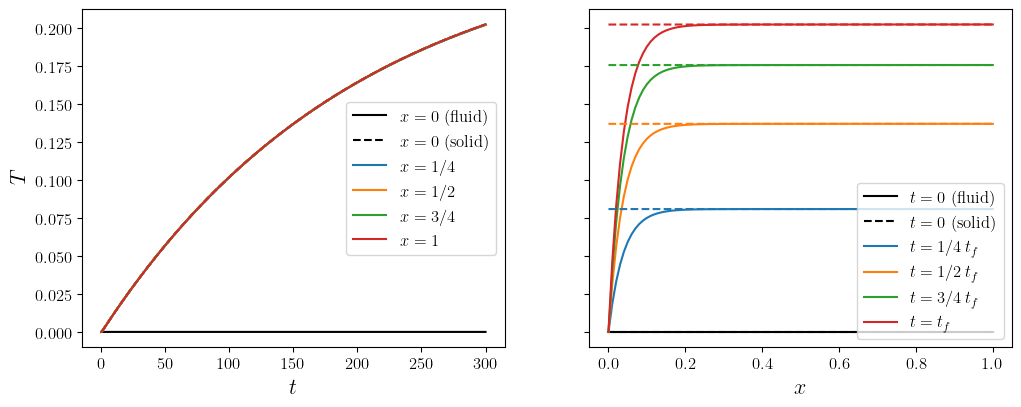

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,12), sharey='all')
(ax1, ax2) = axs

ax1.plot(t, thetaf[0,:]*0, 'k-',
         t, thetas[0,:], 'k--',
         t, thetaf[int(1/4*len(x)),:],
         t, thetaf[int(1/2*len(x)),:],
         t, thetaf[int(3/4*len(x)),:],
         t, thetaf[-1,:])

ax1.set_prop_cycle(None)

ax1.plot(t, thetas[int(1/4*len(x)),:], '--',
         t, thetas[int(1/2*len(x)),:], '--',
         t, thetas[int(3/4*len(x)),:], '--',
         t, thetas[-1,:], '--')

ax1.legend([r'$x = 0$ (fluid)', r'$x = 0$ (solid)',
            r'$x = 1/4$', r'$x = 1/2$', r'$x = 3/4$', r'$x = 1$'])
ax1.set_box_aspect(0.8)
ax1.set_xlabel(r'$t$', fontsize=16)
ax1.set_ylabel(r'$T$', fontsize=16)

##

ax2.plot(x, thetaf[:,0], 'k',
         x, thetas[:,0], 'k--',
         x, thetaf[:,int(1/4*len(t))], 
         x, thetaf[:,int(2/4*len(t))],
         x, thetaf[:,int(3/4*len(t))],
         x, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

ax2.plot(x, thetas[:,int(1/4*len(t))], '--', 
         x, thetas[:,int(2/4*len(t))], '--',
         x, thetas[:,int(3/4*len(t))], '--',
         x, thetas[:,-1], '--')

ax2.legend([r'$t = 0$ (fluid)', r'$t = 0$ (solid)',
            r'$t = 1/4 \,t_f$', r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'])
ax2.set_box_aspect(0.8)
ax2.set_xlabel(r'$x$', fontsize=16)

fig.savefig('./figs/DNS_T_vs_x_vs_t_subplot_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

# Simulación por las características

In [19]:
# Malla características
CFL = dt/dx

dtc = dt
dxc = dtc

xc = np.arange(0, 1 + dxc, dxc)
tc = np.arange(0, tf + dtc, dtc)

In [20]:
# Discretización
xvc, tvc = np.meshgrid(xc, tc, indexing='ij')

Cp = xvc*0
Cn = xvc*0

Tsc = xvc*0
Tfc = xvc*0

# BCs
Tfc[0,:] = Tin

# ICs
Tfc[:,0] = 0
Tsc[:,0] = 0

# Valor inicial de las características
Cp[:,0] = tc[0] + xc
Cn[:,0] = xc

Matrix assembly

In [21]:
A = [[1 + 0.5*Lambda*dtc, -0.5*Lambda*dtc],
    [-0.5*Lambdas*dtc, 1 + 0.5*Lambdas*dtc]]
Ainv = np.linalg.inv(A)

In [22]:
Qc = np.tanh(tc/Delta)*np.exp(-(1/delta)*(xc[:,np.newaxis] - x0)**2)/np.sqrt(np.pi*delta)

In [23]:
# Numerical integration by using explicit Euler
for j in range(1,len(tc)): 
    Cp[:,j] = tc[j] + xc
    Cn[:,j] = xc

    for i in range(1,len(xc)):
        
        # Tfc[i,j], Tsc[i-1,j] = Ainv.dot([-0.5*Lambda*(Tfc[i-1,j-1] - Tsc[i-1,j-1])*dtc + Tfc[i-1,j-1] + eps*dtc*Qc[i-1,j-1],
        #                                 0.5*Lambdas*(Tfc[i-1,j-1] - Tsc[i-1,j-1])*dtc + Tsc[i-1,j-1] + gamma*dtc*Qc[i-1,j-1]])
   

        Tfc[i,j], Tsc[i-1,j] = Ainv.dot([-0.5*Lambda*(Tfc[i-1,j-1] - Tsc[i-1,j-1])*dtc + Tfc[i-1,j-1],
                                          0.5*Lambdas*(Tfc[i-1,j-1] - Tsc[i-1,j-1])*dtc + Tsc[i-1,j-1] +
                                         dtc*gamma*Qc[i-1,j-1]])    

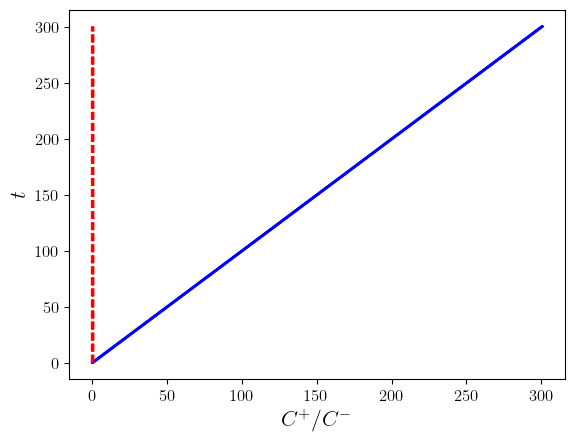

In [24]:
fig, axs = plt.subplots()

axs.plot(Cp[::int(len(xc)/4 - 1),:].T, tc, 'b-')
axs.plot(Cn[::int(len(xc)/4 - 1),:].T, tc, 'r--')

axs.set_ylabel(r'$t$', fontsize=16)
axs.set_xlabel(r'$C^+/C^-$', fontsize=16)

fig.savefig('./figs/characteristics_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

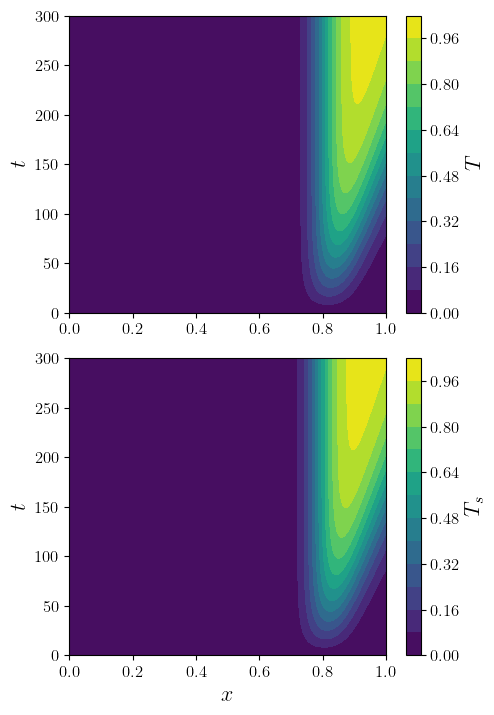

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,7), sharex='row')
(ax1, ax2) = axs

cs1 = ax1.contourf(xvc, tvc, Tfc, 12, dpi=300)
plt.tight_layout()
cbar1 = plt.colorbar(cs1)
cbar1.set_label(r'$T$', fontsize=16)
ax1.set_ylabel(r'$t$', fontsize=16)
# ax1.plot(xc, xc,'r--', label=r'$x = t$')


cs2 = ax2.contourf(xvc, tvc, Tsc, 12, dpi=300)
plt.tight_layout()
cbar2 = plt.colorbar(cs2)
cbar2.set_label(r'$T_s$', fontsize=16)
ax2.set_ylabel(r'$t$', fontsize=16)
# ax2.set_box_aspect(1)
# ax2.plot(xc, xc,'r--', label=r'$x = t$')
ax2.set_xlim([0, 1])
#ax2.set_ylim([0, 1])
ax2.set_xlabel(r'$x$', fontsize=16)

fig.savefig('./figs/char_T_vs_x_vs_t_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

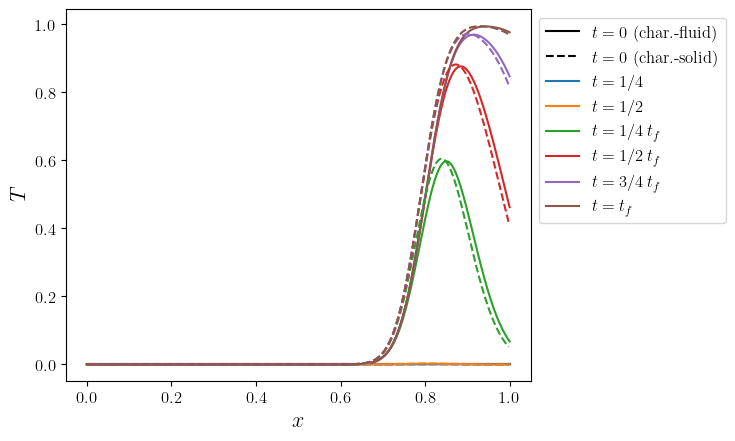

In [26]:
fig, ax = plt.subplots(figsize=(6,8))

plt.plot(xc, Tfc[:,0], 'k-', xc, Tsc[:,0], 'k--',
         xc, Tfc[:,int(0.25/dtc)], xc, Tfc[:,int(0.5/dtc)],
         xc, Tfc[:,int(1/4*len(tc))], xc, Tfc[:,int(2/4*len(tc))],
         xc, Tfc[:,int(3/4*len(tc))], xc, Tfc[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(xc[:-1], Tsc[:-1,int(0.25/dtc)], '--', xc[:-1], Tsc[:-1,int(0.5/dtc)], '--',
         xc[:-1], Tsc[:-1,int(1/4*len(tc))], '--', xc[:-1], Tsc[:-1,int(2/4*len(tc))], '--',
         xc[:-1], Tsc[:-1,int(3/4*len(tc))], '--', xc[:-1], Tsc[:-1,-1], '--')

plt.legend([r'$t = 0$ (char.-fluid)', r'$t = 0$ (char.-solid)',
            r'$t = 1/4$',r'$t = 1/2$',r'$t = 1/4 \,t_f$',
            r'$t = 1/2 \,t_f$', r'$t = 3/4 \,t_f$', r'$t = t_f$'], bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)
fig.savefig('./figs/char_Tf_Ts_vs_x_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

# Profiles comparison: DNS vs. characteristics

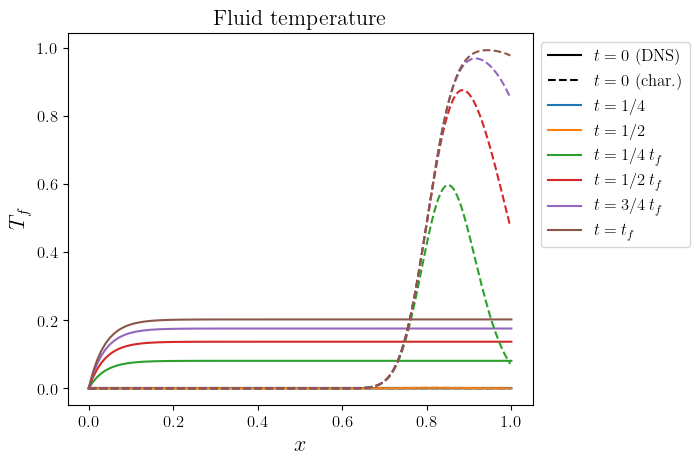

In [27]:
fig, ax = plt.subplots(figsize=(6,8))

plt.plot(x, thetaf[:,0], 'k',
         xc, Tfc[:,0], 'k--',
         x, thetaf[:,int(0.25/dt)],
         x, thetaf[:,int(0.50/dt)],
         x, thetaf[:,int(1/4*len(t))],
         x, thetaf[:,int(2/4*len(t))],
         x, thetaf[:,int(3/4*len(t))],
         x, thetaf[:,-1])

plt.gca().set_prop_cycle(None)

plt.plot(xc[:-1], Tfc[:-1,int(0.25/dtc)], '--',
         xc[:-1], Tfc[:-1,int(0.50/dtc)], '--',
         xc[:-1], Tfc[:-1,int(1/4*len(tc))], '--',
         xc[:-1], Tfc[:-1,int(2/4*len(tc))], '--',
         xc[:-1], Tfc[:-1,int(3/4*len(tc))], '--',
         xc[:-1], Tfc[:-1,-1], '--')

plt.title(r'Fluid temperature')

plt.legend([r'$t = 0$ (DNS)', r'$t = 0$ (char.)',
            r'$t = 1/4$', r'$t = 1/2$',
            r'$t = 1/4 \,t_f$', r'$t = 1/2 \,t_f$',
            r'$t = 3/4 \,t_f$', r'$t = t_f$'], bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T_f$', fontsize=16)
fig.savefig('./figs/DNS_vs_characteristics_fluid_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()

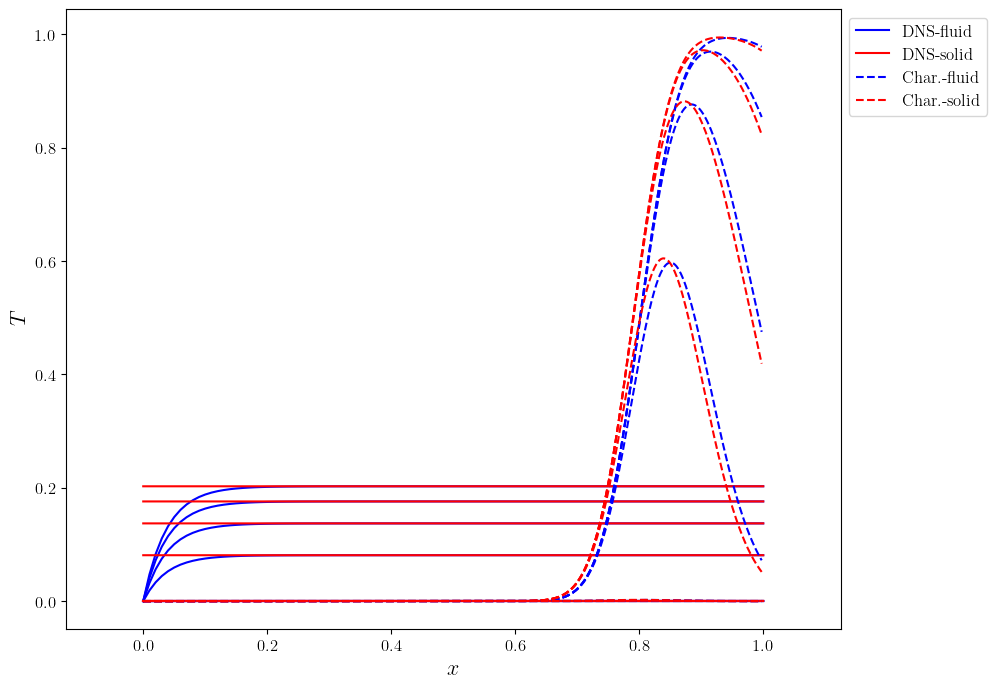

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

# DNS - fluid
plt.plot(x, thetaf[:,0], 'b-')
plt.plot(xc, Tfc[:,0], 'b--')
plt.plot(x, thetas[:,0], 'r-')
plt.plot(xc[:-1], Tsc[:-1,0], 'r--')

plt.plot(x, thetaf[:,int(0.25/dt)], 'b-', label='DNS-fluid')
plt.plot(x, thetaf[:,int(0.50/dt)], 'b-')
plt.plot(x, thetaf[:,int(1/4*len(t))], 'b-')
plt.plot(x, thetaf[:,int(2/4*len(t))], 'b-')
plt.plot(x, thetaf[:,int(3/4*len(t))], 'b-')
plt.plot(x, thetaf[:,-1], 'b-')

# DNS - solid
plt.plot(x, thetas[:,int(0.25/dt)], 'r-')
plt.plot(x, thetas[:,int(0.50/dt)], 'r-')
plt.plot(x, thetas[:,int(1/4*len(t))], 'r-', label='DNS-solid')
plt.plot(x, thetas[:,int(2/4*len(t))], 'r-')
plt.plot(x, thetas[:,int(3/4*len(t))], 'r-')
plt.plot(x, thetas[:,-1], 'r-')

# Char. - fluid
plt.plot(xc[:-1], Tfc[:-1,int(0.25/dtc)], 'b--')
plt.plot(xc[:-1], Tfc[:-1,int(0.50/dtc)], 'b--')
plt.plot(xc[:-1], Tfc[:-1,int(1/4*len(tc))], 'b--', label='Char.-fluid')
plt.plot(xc[:-1], Tfc[:-1,int(2/4*len(tc))], 'b--')
plt.plot(xc[:-1], Tfc[:-1,int(3/4*len(tc))], 'b--')
plt.plot(xc[:-1], Tfc[:-1,-1], 'b--')

# Char. - solid
plt.plot(xc[:-1], Tsc[:-1,int(0.25/dtc)], 'r--')
plt.plot(xc[:-1], Tsc[:-1,int(0.50/dtc)], 'r--')
plt.plot(xc[:-1], Tsc[:-1,int(1/4*len(tc))], 'r--', label='Char.-solid')
plt.plot(xc[:-1], Tsc[:-1,int(2/4*len(tc))], 'r--')
plt.plot(xc[:-1], Tsc[:-1,int(3/4*len(tc))], 'r--')
plt.plot(xc[:-1], Tsc[:-1,-1], 'r--')

# Average T
# plt.plot(xc + 0.05, xc*0 + 0.5, 'k-.')

'''
# Cosmetics
plt.text(0.83, 0.53, r'$T_{in}/2$', fontsize=14)
plt.arrow(-0.05, 0.85, 1, -0.5, width=0.0001, color='k', head_width=0.0125, head_length=0.025, lw=0.5)
plt.text(0.80, 0.25, r'$t = 1/4,\, 1/2,\,1/4\,t_f,$', fontsize=12) 
plt.text(0.865, 0.20, r'$1/2\,t_f,3/4\,t_f,\,t_f.$', fontsize=12)
'''

plt.xlim([-0.125, xc[-1] + 0.125])

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_box_aspect(0.8)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$T$', fontsize=16)

fig.savefig('./figs/DNS_vs_characteristics_all_Lambda_' + str(np.round(Lambda, 2))
            + '_Lambdas_' + str(np.round(Lambdas, 2)) + '_beta_' + str(np.round(beta, 2)) +
            '_betas_' + str(np.round(betas, 2)) + '.pdf', bbox_inches='tight')
plt.show()


## Valores típicos de los parámetros - Sandia Lab (Hoffman et al., 2016)

In [29]:
eps = 0.22
L = 3
R = 1.5
mdot = 5.46
dp = 19.1e-3
T = 0.5*(359.9 + 289) + 273 #Kelvin

# Molten salts properties
rhof = 2090 - 0.636*T
Cf = 1443 + 0.172*T
kf = 0.443 + 0.000019*T
muf = (22.174 - 0.12*T + 2.281e-4*T**2 - 1.474e-7*T**3)/1e3

# Quartzite properties
rhos = 2500
Cs = 830
ks = 5.69

# Fluid flow
u = mdot/(rhof*np.pi*eps*R**2)

Re = rhof*u*dp/muf
Pr = muf*Cf/kf

# Vol heat transfer coeff
hv = 6*(1 - eps)*kf*(2 + 1.1*Re**0.6*Pr**(1/3))/(dp**2)

# Coefficients
Lambda = hv*L/(rhof*Cf*u*eps)
Lambdas = hv*L/(rhos*Cs*u*(1-eps))

beta = kf/(L*u)
betas = ks/(L*u)

gamma = eps*rhof*Cf/(rhos*Cs)

q0 = 1

print('Lambda = ', np.round(Lambda, 4))
print('Lambdas = ', np.round(Lambdas, 4))
print('beta = ', np.round(beta, 4))
print('betas = ', np.round(betas, 4))
print('gamma = ', np.round(gamma, 4))
print('q0 = ', np.round(q0, 4))
print('Re = ', np.round(Re, 4))
print('Pr = ', np.round(Pr, 4))
print('dp/L = ', np.round(dp/L, 4))
print('R/L = ', np.round(R/L, 4))
print('eps = ', np.round(eps, 4))
print('hv = ', np.round(hv, 4), 'W/(m^3 K)')

Lambda =  399.8138
Lambdas =  143.6521
beta =  73.7624
betas =  923.7514
gamma =  0.2803
q0 =  1
Re =  144.1202
Pr =  1.5831
dp/L =  0.0064
R/L =  0.5
eps =  0.22
hv =  159125.3059 W/(m^3 K)


## Valores típicos de los parámetros - Solar One (Hoffman et al., 2016)

In [30]:
eps = 0.22
L = 12
R = 18.2/2
mdot = 23
dp = 4.6e-3
T = 0.5*(295.5 + 192.2) + 273 #Kelvin

# Molten salts properties
rhof = 871.1 - 0.713*T
Cf = 1836.8 + 3.456*T
kf = 0.125 + 0.000014*T
muf = 72.159*T**(-2.096)

# Granite rock and sand properties
rhos = 2643
Cs = 1020
ks = 2.2

# Fluid flow
u = mdot/(rhof*np.pi*eps*R**2)

Re = rhof*u*dp/muf
Pr = muf*Cf/kf

# Vol heat transfer coeff
hv = 6*(1 - eps)*kf*(2 + 1.1*Re**0.6*Pr**(1/3))/(dp**2)

# Coefficients
Lambda = hv*L/(rhof*Cf*u*eps)
Lambdas = hv*L/(rhos*Cs*u*(1-eps))

beta = kf/(L*u)
betas = ks/(L*u)

gamma = eps*rhof*Cf/(rhos*Cs)

q0 = 1

print('Lambda = ', np.round(Lambda, 4))
print('Lambdas = ', np.round(Lambdas, 4))
print('beta = ', np.round(beta, 4))
print('betas = ', np.round(betas, 4))
print('gamma = ', np.round(gamma, 4))
print('q0 = ', np.round(q0, 4))
print('Re = ', np.round(Re, 4))
print('Pr = ', np.round(Pr, 4))
print('dp/L = ', np.round(dp/L, 4))
print('R/L = ', np.round(R/L, 4))
print('eps = ', np.round(eps, 4))
print('hv = ', np.round(hv, 4), 'W/(m^3 K)')

Lambda =  10930.5923
Lambdas =  2082.3664
beta =  13.7818
betas =  229.2869
gamma =  0.1486
q0 =  1
Re =  12.4667
Pr =  4.0626
dp/L =  0.0004
R/L =  0.7583
eps =  0.22
hv =  291762.8472 W/(m^3 K)


## Valores típicos de los parámetros - Promes CNRS (Hoffman et al., 2016)

In [31]:
eps = 0.41
L = 1.8
R = 0.2
mdot = 1.9e-2
dp = 40e-3
T = 0.5*(210 + 160) + 273 #Kelvin

# Rapeseed oil properties
rhof = 928.19 - 0.6691*T
Cf = (1.621e-9*T**4 - 8.735e-7*T**3 + 14.933e-5*T**2 - 5.976e-3*T + 2.0985)*1000
kf = 2e-7*T**2 + 1.714e-4*T + 0.1698
muf = (39.498*T**(-1.764))/1000

# Quartzite properties
rhos = 2500
Cs = 830
ks = 5.69

# Fluid flow
u = mdot/(rhof*np.pi*eps*R**2)

Re = rhof*u*dp/muf
Pr = muf*Cf/kf

# Vol heat transfer coeff
hv = 6*(1 - eps)*kf*(2 + 1.1*Re**0.6*Pr**(1/3))/(dp**2)

# Coefficients
Lambda = hv*L/(rhof*Cf*u*eps)
Lambdas = hv*L/(rhos*Cs*u*(1-eps))

beta = kf/(L*u)
betas = ks/(L*u)

gamma = (1-eps)*Lambdas/Lambda

q0 = 1

print('Lambda = ', np.round(Lambda, 4))
print('Lambdas = ', np.round(Lambdas, 4))
print('beta = ', np.round(beta, 4))
print('betas = ', np.round(betas, 4))
print('gamma = ', np.round(gamma, 4))
print('q0 = ', np.round(q0, 4))
print('Re = ', np.round(Re, 4))
print('Pr = ', np.round(Pr, 4))
print('dp/L = ', np.round(dp/L, 4))
print('R/L = ', np.round(R/L, 4))
print('eps = ', np.round(eps, 4))
print('hv = ', np.round(hv, 4), 'W/(m^3 K)')

Lambda =  62.8946
Lambdas =  236.9355
beta =  271.8668
betas =  5329.5461
gamma =  2.2226
q0 =  1
Re =  18450.6414
Pr =  0.0498
dp/L =  0.0222
R/L =  0.1111
eps =  0.41
hv =  95582.2686 W/(m^3 K)


## Valores típicos de los parámetros (Hänchen et al., 2011)

In [32]:
eps = 0.36
L = 25
R = 7
mdot = 119
dp = 0.1
T = 0.5*(550 + 150) + 273 #Kelvin

# Heated air properties
rhof = cpr.PropsSI('D', 'T', T, 'P', 5e5, 'Air')
Cf = cpr.PropsSI('C', 'T', T, 'P', 5e5, 'Air')
kf = cpr.PropsSI('L', 'T', T, 'P', 5e5, 'Air')
muf = cpr.PropsSI('V', 'T', T, 'P', 5e5, 'Air')

# Filler properties
rhos = 2800
Cs = 1030
ks = 2.5

# Fluid flow
u = mdot/(rhof*np.pi*eps*R**2)

Re = rhof*u*dp/muf
Pr = muf*Cf/kf

# Vol heat transfer coeff
hv = 6*(1 - eps)*kf*(2 + 1.1*Re**0.6*Pr**(1/3))/(dp**2)

# Coefficients
Lambda = hv*L/(rhof*Cf*u*eps)
Lambdas = hv*L/(rhos*Cs*u*(1-eps))

beta = kf/(L*u)
betas = ks/(L*u)

gamma = (1 - eps)*Lambdas/Lambda

q0 = 1

print('Lambda = ', np.round(Lambda, 4))
print('Lambdas = ', np.round(Lambdas, 4))
print('beta = ', np.round(beta, 4))
print('betas = ', np.round(betas, 4))
print('gamma = ', np.round(gamma, 4))
print('q0 = ', np.round(q0, 4))
print('Re = ', np.round(Re, 4))
print('Pr = ', np.round(Pr, 4))
print('dp/L = ', np.round(dp/L, 4))
print('R/L = ', np.round(R/L, 4))
print('eps = ', np.round(eps, 4))
print('hv = ', np.round(hv, 4), 'W/(m^3 K)')

Lambda =  109.6789
Lambdas =  0.0631
beta =  0.0025
betas =  0.13
gamma =  0.0004
q0 =  1
Re =  6794.0052
Pr =  0.7051
dp/L =  0.004
R/L =  0.28
eps =  0.36
hv =  3587.1442 W/(m^3 K)


## Valores típicos de los parámetros (Stack et al., 2017)

In [33]:
eps = np.array([0.25, 0.30, 0.35, 0.4, 0.5])
L = 1
R = 2
X = R/L
mdot = np.array([0.01, 0.05, 0.5, 1, 50, 100, 150, 200, 500]) #189.5
dp = 0.015
T = 0.5*(100 + 1200) + 273 #Kelvin

p0 = 1e6

# Heated air properties
rhof = cpr.PropsSI('D', 'T', T, 'P', p0, 'Air')
Cf = cpr.PropsSI('C', 'T', T, 'P', p0, 'Air')
kf = cpr.PropsSI('L', 'T', T, 'P', p0, 'Air')
muf = cpr.PropsSI('V', 'T', T, 'P', p0, 'Air')

# Filler properties
rhos = 3987
Cs = 840
ks = 15

# Fluid flow
u = mdot[:,np.newaxis]/(rhof*np.pi*eps*R**2)
u = 10

Re = rhof*u*2*R/muf
dpByD = dp/(2*R)
Rep = Re*dpByD # rhof*u*dp/muf
Pr = muf*Cf/kf

# Vol heat transfer coeff
hv = 6*(1 - eps)*kf*(2 + 1.1*Rep**0.6*Pr**(1/3))/(dp**2)
# hv = 700*(mdot[:,np.newaxis]/(dp*np.pi*R**2))**0.76

# Coefficients
Lambda = hv*L/(rhof*Cf*u*eps)
Lambdas = hv*L/(rhos*Cs*u*(1-eps))
xi = rhof*Cf/(rhos*Cs)

# --

beta = kf/(L*u)
betas = ks/(L*u)
kappa = ks/kf

# gamma = (1 - eps)*Lambdas/Lambda
gamma = Lambdas/Lambda

power = mdot*Cf*(1700 - 25)

print('Xi = ', np.round(xi, 4))
print('kappa = ', np.round(kappa, 4))
print('R/L = ', np.round(R/L, 4))
print('Rep = ', np.round(Rep, 4))
print('Re = ', np.round(Re, 4))
print('Lambda = ', np.round(Lambda, 4))
print('Lambdas = ', np.round(Lambdas, 4))
print('beta = ', np.round(beta, 4))
print('betas = ', np.round(betas, 4))
print('eps = ', np.round(eps, 4))

print('gamma = ', np.round(gamma, 4))
print('power = ', np.round(power/1e6, 4), 'MW')

print('Pr = ', np.round(Pr, 4))
print('dp/L = ', np.round(dp/L, 4))

print('hv = ', np.round(hv, 4), 'W/(m^3 K)')

Xi =  0.0013
kappa =  235.0374
R/L =  2.0
Rep =  13723.4655
Re =  3659590.8011
Lambda =  [36.4074 28.3169 22.5379 18.2037 12.1358]
Lambdas =  [0.0154 0.0154 0.0154 0.0154 0.0154]
beta =  0.0064
betas =  1.5
eps =  [0.25 0.3  0.35 0.4  0.5 ]
gamma =  [0.0004 0.0005 0.0007 0.0008 0.0013]
power =  [1.890000e-02 9.440000e-02 9.437000e-01 1.887300e+00 9.436500e+01
 1.887301e+02 2.830951e+02 3.774601e+02 9.436504e+02] MW
Pr =  0.726
dp/L =  0.015
hv =  [385815.1438 360094.1342 334373.1247 308652.1151 257210.0959] W/(m^3 K)


In [34]:
100*rhof*Cf*0.5

211943.18612720206

In [35]:
hv*L/u

array([38581.51438296, 36009.4134241 , 33437.31246524, 30865.21150637,
       25721.00958864])